In [1]:

import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/sharvarisoparkar/Desktop/MiniProject/TomatoDetection",
    seed=10,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 18345 files belonging to 9 classes.


In [6]:

class_names =dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 4 0 5 8 8 1 2 4 6 2 6 5 0 0 8 6 1 8 4 5 6 4 6 5 2 0 0 0 0 0 7]


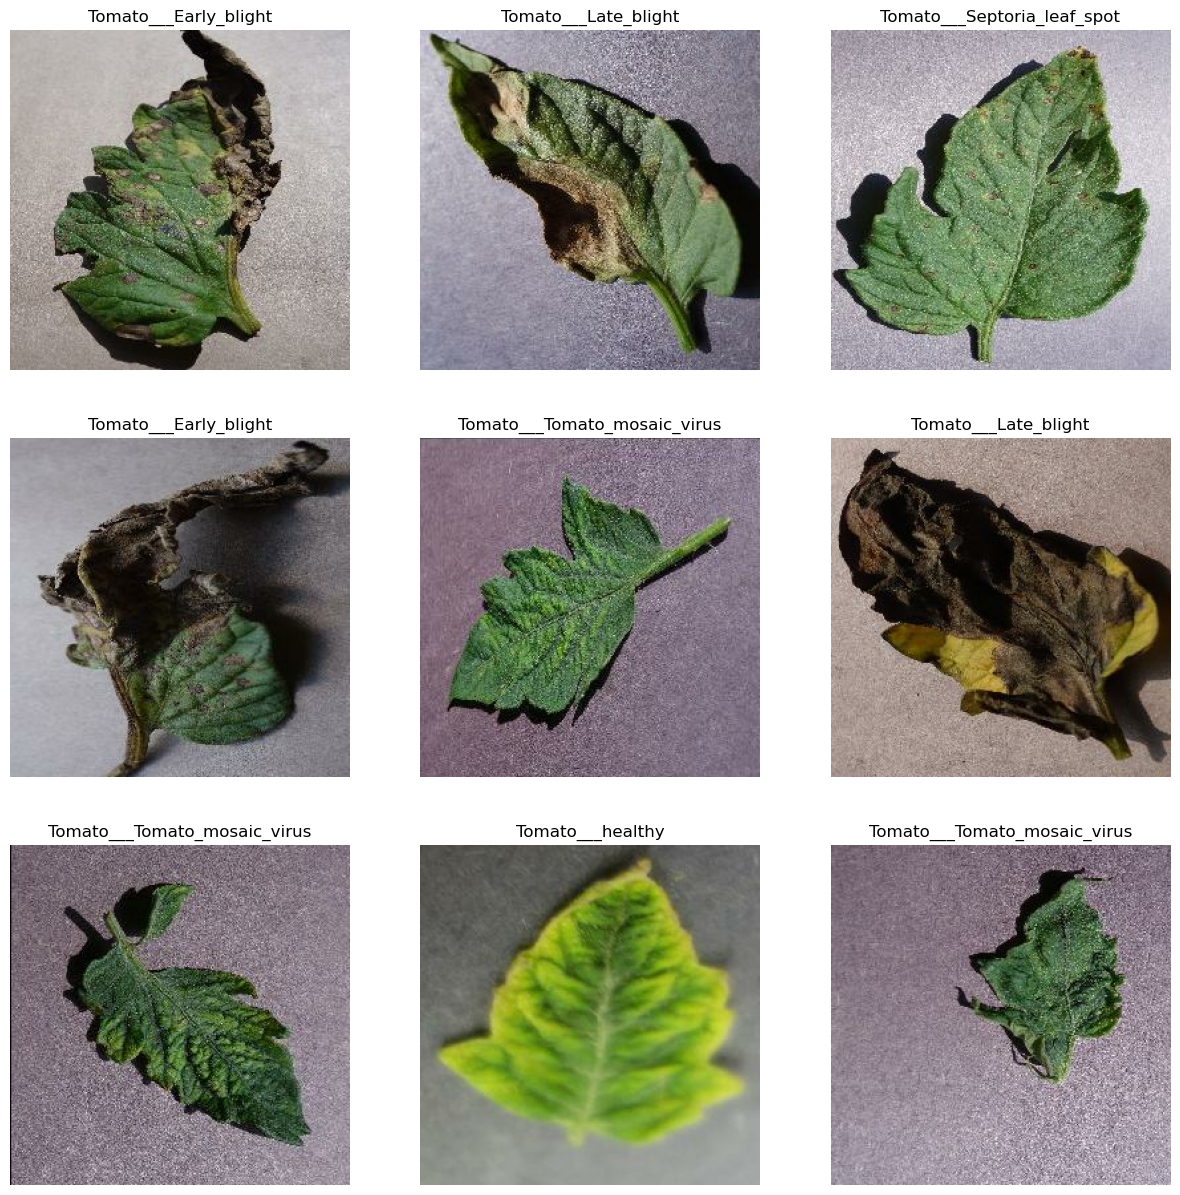

In [8]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

574

In [29]:
train_size = 0.7
len(dataset)*train_size

401.79999999999995

In [30]:
train_ds = dataset.take(54)
len(train_ds)

54

In [31]:
test_ds = dataset.skip(54)
len(test_ds)

520

In [32]:
val_size=0.1
len(dataset)*val_size

57.400000000000006

In [33]:

val_ds = test_ds.take(6)
len(val_ds)


6

In [34]:
test_ds = test_ds.skip(6)
len(test_ds)

514

In [45]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [46]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [47]:
len(train_ds)

401

In [48]:
len(val_ds)

114

In [49]:
len(test_ds)

59

In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [51]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


In [52]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [53]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [54]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [55]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:


history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)



Epoch 1/10


2023-11-30 21:53:03.371058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 296 of 1000
2023-11-30 21:53:14.230457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:58: Filling up shuffle buffer (this may take a while): 395 of 1000
2023-11-30 21:53:14.452656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


401/401 [==============================] - 720s 2s/step - loss: 1.8825 - accuracy: 0.3043 - val_loss: 1.5405 - val_accuracy: 0.4457
Epoch 2/10
401/401 [==============================] - 649s 2s/step - loss: 1.1301 - accuracy: 0.5903 - val_loss: 1.0245 - val_accuracy: 0.6560
Epoch 3/10
401/401 [==============================] - 628s 2s/step - loss: 0.7325 - accuracy: 0.7401 - val_loss: 0.8750 - val_accuracy: 0.7141
Epoch 4/10
401/401 [==============================] - 637s 2s/step - loss: 0.5428 - accuracy: 0.8107 - val_loss: 0.8338 - val_accuracy: 0.7366
Epoch 5/10
401/401 [==============================] - 623s 2s/step - loss: 0.4627 - accuracy: 0.8422 - val_loss: 1.0939 - val_accuracy: 0.6582
Epoch 6/10
401/401 [==============================] - 815s 2s/step - loss: 0.3990 - accuracy: 0.8618 - val_loss: 0.9504 - val_accuracy: 0.7338
Epoch 7/10
401/401 [==============================] - 622s 2s/step - loss: 0.3412 - accuracy: 0.8826 - val_loss: 0.9348 - val_accuracy: 0.7393
Epoch 8/10

In [58]:
scores = model.evaluate(test_ds)

59/59 [==============================] - 28s 348ms/step - loss: 0.4602 - accuracy: 0.8332


In [59]:
scores

[0.46016374230384827, 0.8332439661026001]

first image to predict
actual label: Tomato___Target_Spot
1/1 [==============================] - 1s 687ms/step
predicted label: Tomato___Target_Spot


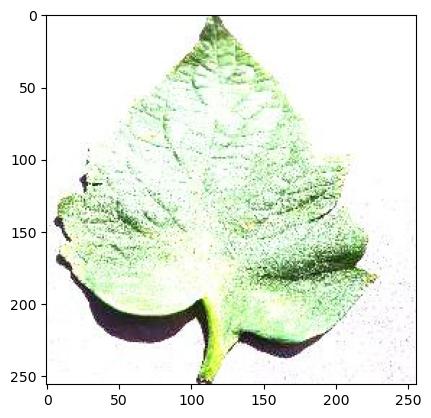

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [62]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


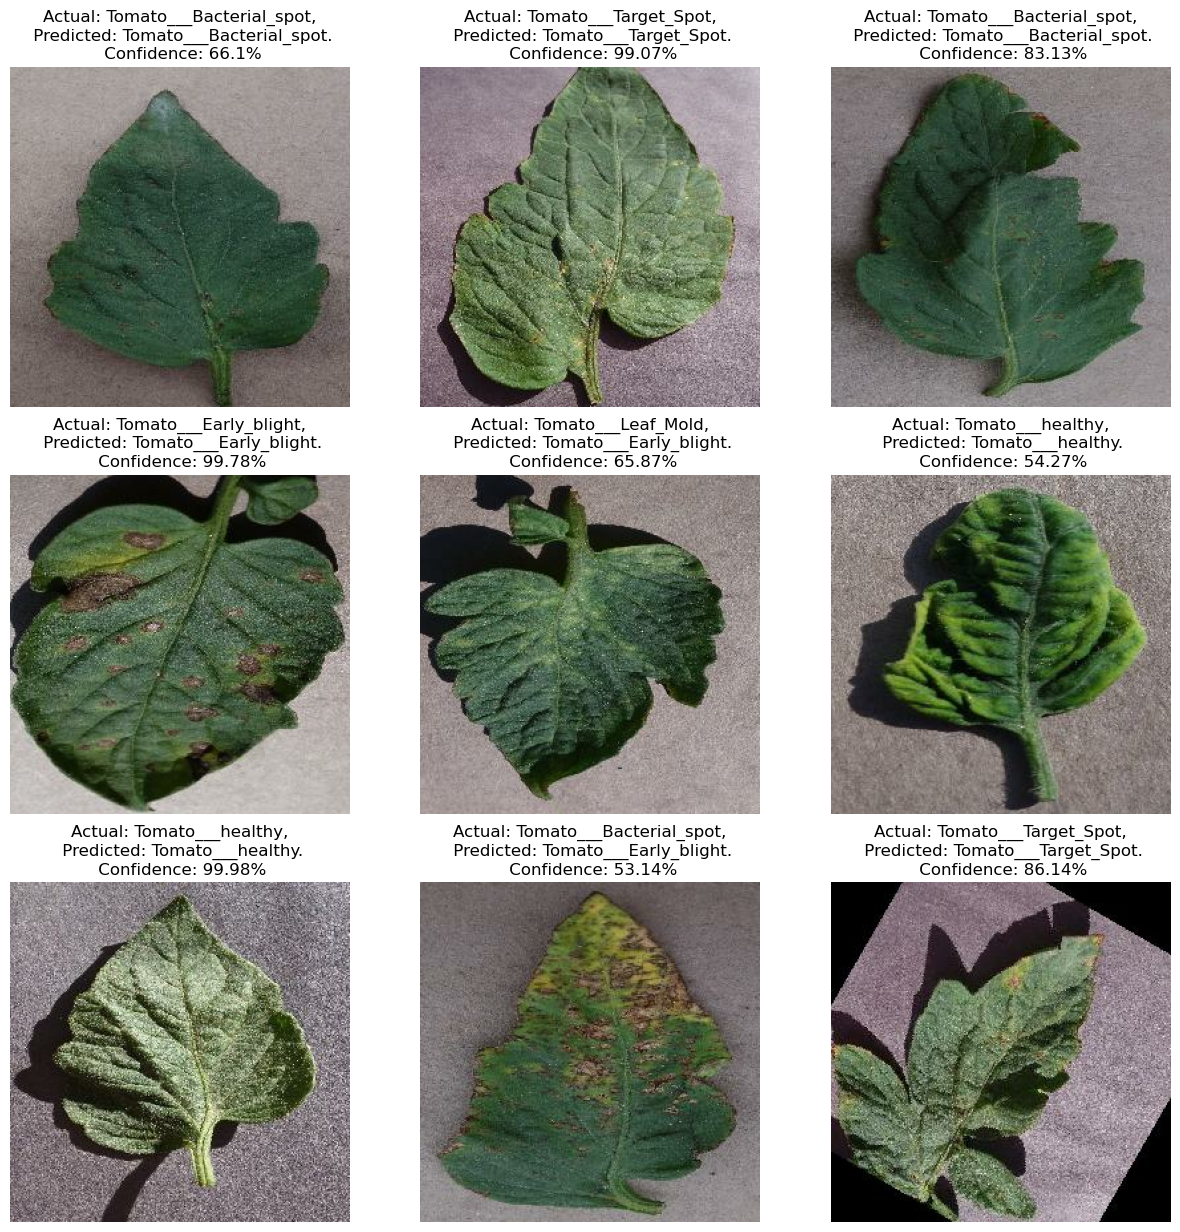

In [63]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [64]:
model_version=4
model.save(f'/Users/sharvarisoparkar/Desktop/MiniProject/Models/{model_version}')

INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/4/assets


INFO:tensorflow:Assets written to: /Users/sharvarisoparkar/Desktop/MiniProject/Models/4/assets
